# Prediction on bigger flight (Raster) with New Full Model

In [1]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
import numpy as np
from matplotlib import colors
from osgeo import gdal
import matplotlib.pyplot as plt
import warnings
import pandas as d
warnings.filterwarnings("ignore")

def scaleMinMax(x):
    return((x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x)))

def scaleCCC(x):
    return((x- np.nanpercentile(x,0))/(np.nanpercentile(x,98)-np.nanpercentile(x,0)))



/Users/bfrd/mambaforge/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/bfrd/mambaforge/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: <BE0CCD9A-269A-30E2-A23C-DA45E89EBB1F> /Users/bfrd/mambaforge/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/bfrd/mambaforge/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Users/bfrd/mambaforge/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Users/bfrd/mambaforge/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/Users/bfrd/mambaforge/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file, not in dyld cache)
  warn(f"Failed to load image Python extension: {e}")


In [2]:
lowtif = gdal.Open('/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Gafanha_high_multi.tif')

Warning 1: /Users/bfrd/Research/BigData/Nantes/Drone_Classification/Gafanha_high_multi.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [3]:
gt = lowtif.GetGeoTransform()
proj = lowtif.GetProjection()

In [6]:
### 65535 is given for NA (outside of Drone flight)

Reflectance_444 = lowtif.GetRasterBand(1).ReadAsArray().astype('float')
Reflectance_475 = lowtif.GetRasterBand(2).ReadAsArray().astype('float')
Reflectance_531 = lowtif.GetRasterBand(3).ReadAsArray().astype('float')
Reflectance_560 = lowtif.GetRasterBand(4).ReadAsArray().astype('float')
Reflectance_650 = lowtif.GetRasterBand(5).ReadAsArray().astype('float')
Reflectance_668 = lowtif.GetRasterBand(6).ReadAsArray().astype('float')
Reflectance_705 = lowtif.GetRasterBand(7).ReadAsArray().astype('float')
Reflectance_717 = lowtif.GetRasterBand(8).ReadAsArray().astype('float')
Reflectance_740 = lowtif.GetRasterBand(9).ReadAsArray().astype('float')
Reflectance_842 = lowtif.GetRasterBand(10).ReadAsArray().astype('float')

Reflectance_444[Reflectance_444 == 65535] = np.NAN
Reflectance_475[Reflectance_475 == 65535] = np.NAN
Reflectance_531[Reflectance_531 == 65535] = np.NAN
Reflectance_560[Reflectance_560 == 65535] = np.NAN
Reflectance_650[Reflectance_650 == 65535] = np.NAN
Reflectance_668[Reflectance_668 == 65535] = np.NAN
Reflectance_705[Reflectance_705 == 65535] = np.NAN
Reflectance_717[Reflectance_717 == 65535] = np.NAN
Reflectance_740[Reflectance_740 == 65535] = np.NAN
Reflectance_842[Reflectance_842 == 65535] = np.NAN

Full = np.dstack((Reflectance_444,Reflectance_475,Reflectance_531,Reflectance_560,Reflectance_650,
                  Reflectance_668,Reflectance_705,Reflectance_717,Reflectance_740,Reflectance_842))

Full.shape


(18157, 16402, 10)

In [7]:
FullStan=np.apply_along_axis(scaleMinMax, 2, Full)

In [9]:
Full_ten = torch.from_numpy(Full)
FullStan_ten =torch.from_numpy(FullStan)

In [10]:
NDVI=(Full_ten[:,:,9]-Full_ten[:,:,5])/(Full_ten[:,:,9]+Full_ten[:,:,5])

In [11]:
NDVI=NDVI[:,:,None]

In [12]:
NDVI_Stan=(FullStan_ten[:,:,9]-FullStan_ten[:,:,5])/(FullStan_ten[:,:,9]+FullStan_ten[:,:,5])

In [13]:
NDVI_Stan=NDVI_Stan[:,:,None]

In [14]:
FullCombo_ten=torch.cat((Full_ten,FullStan_ten,NDVI,NDVI_Stan),2)

In [15]:
r = scaleCCC(Reflectance_650)
g = scaleCCC(Reflectance_531)
b = scaleCCC(Reflectance_444)

rgb = np.dstack((r,g,b))

In [16]:
Reflectance_444= None
Reflectance_475= None
Reflectance_531= None
Reflectance_560= None
Reflectance_650= None
Reflectance_668= None
Reflectance_705= None
Reflectance_717= None
Reflectance_740= None
Reflectance_842= None
r= None
g= None
b= None
Full= None
FullStan= None

In [17]:
torch.save(FullCombo_ten,"/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/FullCombo_Site1_High.pt")

In [2]:
FullCombo_ten=torch.load("/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/FullCombo_Site1_High.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


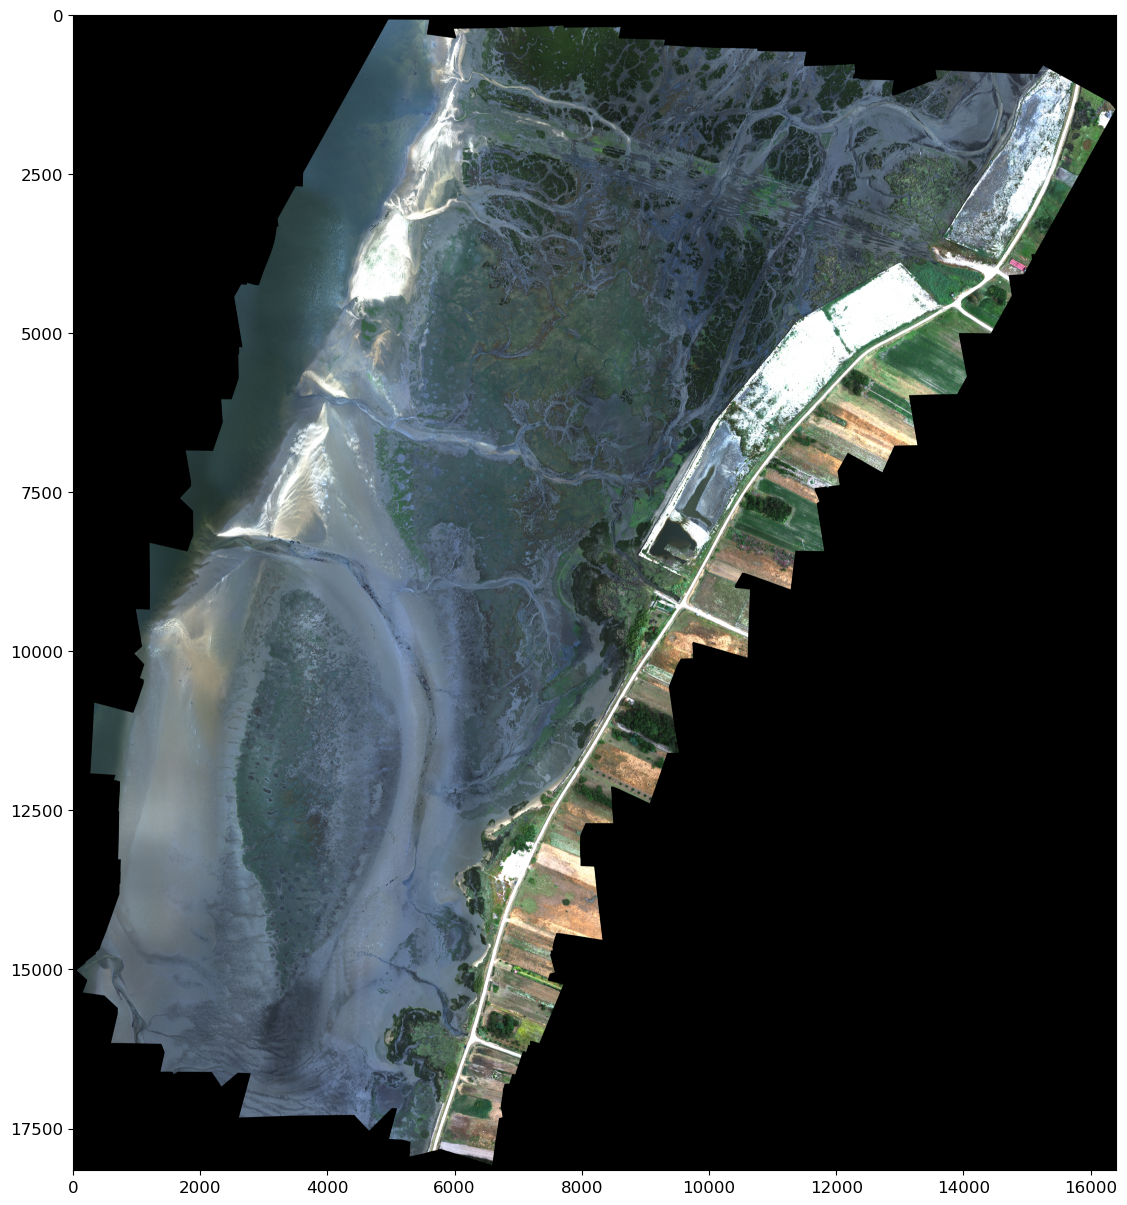

In [18]:
plt.figure(figsize=(15,15))
plt.imshow(rgb)
plt.show()

In [4]:
learn = load_learner('models/nn_NewTrain_StanRawMetrics_NoXanth.pkl')

In [5]:
categories = learn.dls.vocab

In [6]:
categories

['Bare_Sediment', 'Clorophyta', 'Deep_Sediment', 'Low_SPC', 'MPB', 'Magnoliosida', 'Phaeophyta', 'Rhodphyta', 'SunGlint', 'Water']

In [6]:
Columns_test=['Reflectance_444',
              'Reflectance_475',
              'Reflectance_531',
              'Reflectance_560',
              'Reflectance_650',
              'Reflectance_668',
              'Reflectance_705',
              'Reflectance_717',
              'Reflectance_740',
              'Reflectance_842',
              'Reflectance_Stan_444',
              'Reflectance_Stan_475',
              'Reflectance_Stan_531',
              'Reflectance_Stan_560',
              'Reflectance_Stan_650',
              'Reflectance_Stan_668',
              'Reflectance_Stan_705',
              'Reflectance_Stan_717',
              'Reflectance_Stan_740',
              'Reflectance_Stan_842',
              'NDVI',
              'NDVI_Stan']

In [7]:
v = FullCombo_ten.view(FullCombo_ten.shape[0]*FullCombo_ten.shape[1],FullCombo_ten.shape[2])

In [8]:
torch.save(v,"/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/FullCombo_Long_Site1_High.pt")

In [4]:
v=torch.load("/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/FullCombo_Long_Site1_High.pt")

In [9]:
v.shape

torch.Size([297811114, 22])

In [10]:
df_test_nan=pd.DataFrame(v,columns=Columns_test)
df_test_nan_nrum = df_test_nan

In [11]:
df_test_nan.to_parquet("/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/df_test_nan_Site1_High.parquet")

In [12]:
df_test_nan_nrum.to_parquet("/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/df_test_nan_nrum_Site1_High.parquet")

In [5]:
df_test_nan=pd.read_parquet("/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/df_test_nan_Site1_High.parquet")
df_test_nan_nrum=pd.read_parquet("/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/df_test_nan_nrum_Site1_High.parquet")

In [13]:
df_test = df_test_nan.dropna()

In [14]:
df_test.to_parquet("/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/df_test_Site1_High.parquet")

In [6]:
df_test_nan_nrum['ID'] = np.arange(len(df_test_nan_nrum))
df_test_nrum = df_test_nan_nrum.dropna()

In [7]:
df_test_nrum.to_parquet("/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/df_test_nrum_Site1_High.parquet")

In [ ]:
df_test.shape

In [8]:
ID_l=list(df_test_nrum['ID'])

In [9]:
np.save('/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/ID_list_Site1_High.npy',ID_l)

In [4]:
df_test=pd.read_parquet("/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/df_test_Site1_High.parquet")

In [5]:
dl = learn.dls.test_dl(df_test, bs=4000)
preds,_ = learn.get_preds(dl=dl)

In [6]:
np.save('/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/Preds_Site1_High.npy',preds)

In [2]:
preds = np.load('/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/Preds_Site1_High.npy').reshape(159664240,11) #131028429 = df_test.shape[0]

In [16]:
greenAlgae_Probs=preds[:,1]

In [7]:
class_idxs = preds.argmax(axis=1)
res = [learn.dls.vocab[c] for c in class_idxs]

In [8]:
np.save('/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/class_idxs_Site1_High.npy',class_idxs)
np.save('/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/res_Site1_High.npy',res)

In [ ]:
class_idxs = np.load('/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/class_idxs_Site1_High.npy')
res = np.load('/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/res_Site1_High.npy')

In [9]:
class_probs= preds.max(axis=1)

In [10]:
class_probs=class_probs.values

In [11]:
np.save('/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/class_probs_Site1_High.npy',class_probs)

In [15]:
class_probs = np.load('/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/class_probs_Site1_High.npy')

ValueError: Object arrays cannot be loaded when allow_pickle=False

# Prediction Plot 

In [12]:
type(class_idxs.tolist())

list

In [13]:
NumPred= class_idxs.tolist()
PredProbs =class_probs.tolist()

In [14]:
ID_l = np.load('/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/ID_list_Site1_High.npy')

In [15]:
res_df= pd.DataFrame(list(zip(res,NumPred, ID_l,PredProbs)),columns =['Pred_Class','Pred_ID','ID','Prob'])

In [16]:
res_df

,Pred_Class,Pred_ID,ID,Prob
0,SunGlint,8,1185898,1.000000
1,SunGlint,8,1185899,1.000000
2,SunGlint,8,1185900,1.000000
3,SunGlint,8,1185901,1.000000
4,SunGlint,8,1185902,1.000000
...,...,...,...,...
159664235,Phaeophyta,6,296538342,0.999990
159664236,Phaeophyta,6,296538343,0.999975
159664237,Phaeophyta,6,296538344,0.999989
159664238,Phaeophyta,6,296554744,0.999989


In [17]:
res_df.to_parquet("/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/res_df_Site1_High.parquet")

In [18]:
res_df['Pred_ID'].value_counts()

Pred_ID
3    45993865
6    29713451
5    16528398
9    15685838
0    15023479
8    13543952
2    12018885
7     6425929
1     3530747
4     1199696
Name: count, dtype: int64

In [19]:
res_df['Pred_Class'].value_counts()

Pred_Class
Low_SPC          45993865
Phaeophyta       29713451
Magnoliosida     16528398
Water            15685838
Bare_Sediment    15023479
SunGlint         13543952
Deep_Sediment    12018885
Rhodphyta         6425929
Clorophyta        3530747
MPB               1199696
Name: count, dtype: int64

In [7]:
res_df= pd.read_parquet('/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/res_df_Site1_High.parquet')

In [8]:
df_test_nan= pd.read_parquet('/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/df_test_nan_Site1_High.parquet')

In [9]:
df_test_nan['ID']= np.arange(len(df_test_nan))

In [10]:
res_input_df = pd.merge(df_test_nan,res_df, how='left', on = 'ID')

In [11]:
res_input_df

,Reflectance_444,Reflectance_475,Reflectance_531,Reflectance_560,...,ID,Pred_Class,Pred_ID,Prob
0,0.0,0.0,0.0,0.0,...,0,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,...,1,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,...,2,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,...,3,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,...,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
297811109,0.0,0.0,0.0,0.0,...,297811109,NaN,NaN,NaN
297811110,0.0,0.0,0.0,0.0,...,297811110,NaN,NaN,NaN
297811111,0.0,0.0,0.0,0.0,...,297811111,NaN,NaN,NaN
297811112,0.0,0.0,0.0,0.0,...,297811112,NaN,NaN,NaN


In [12]:
res_input_df.to_parquet("/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/res_input_df_Site1_High.parquet")

In [4]:
res_input_df=pd.read_parquet('/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Output/res_input_df_Site1_High.parquet')

In [13]:
res_input_df['Pred_Class'] = np.where((res_input_df['Pred_Class']=='Phaeophyta') & (res_input_df['NDVI']<0.15), 'Water', res_input_df['Pred_Class'])

In [14]:
res_input_df['Pred_ID'] = np.where((res_input_df['Pred_ID']==6) & (res_input_df['NDVI']<0.15), 9, res_input_df['Pred_ID'])

In [15]:
res_input_df['Pred_Class'] = np.where((res_input_df['Pred_Class']=='Low_SPC') & (res_input_df['NDVI']>0.2), 'Magnoliosida', res_input_df['Pred_Class'])
res_input_df['Pred_ID'] = np.where((res_input_df['Pred_ID']==3) & (res_input_df['NDVI']>0.2), 5, res_input_df['Pred_ID'])
res_input_df['Pred_Class'] = np.where((res_input_df['Pred_Class']=='Low_SPC') & (res_input_df['NDVI']<=0.2), 'Bare_Sediment', res_input_df['Pred_Class'])
res_input_df['Pred_ID'] = np.where((res_input_df['Pred_ID']==3) & (res_input_df['NDVI']<=0.2), 0, res_input_df['Pred_ID'])

In [16]:
# Check it has actually worked
res_input_df_Nan= res_input_df.dropna()


In [17]:
Pred_arr = np.asarray(res_input_df['Pred_ID'])

In [18]:
Pred_arr=Pred_arr+1

In [19]:
Prob_arr = np.asarray(res_input_df['Prob'])
Prob_ras = Prob_arr.reshape(18157, 16402)

In [20]:
Pred_ras = Pred_arr.reshape(18157, 16402)

In [21]:
Chloro_ras = np.where(Pred_ras==4, 1, 0)

In [22]:
Zost_ras=np.where(Pred_ras==6, 1, 0)

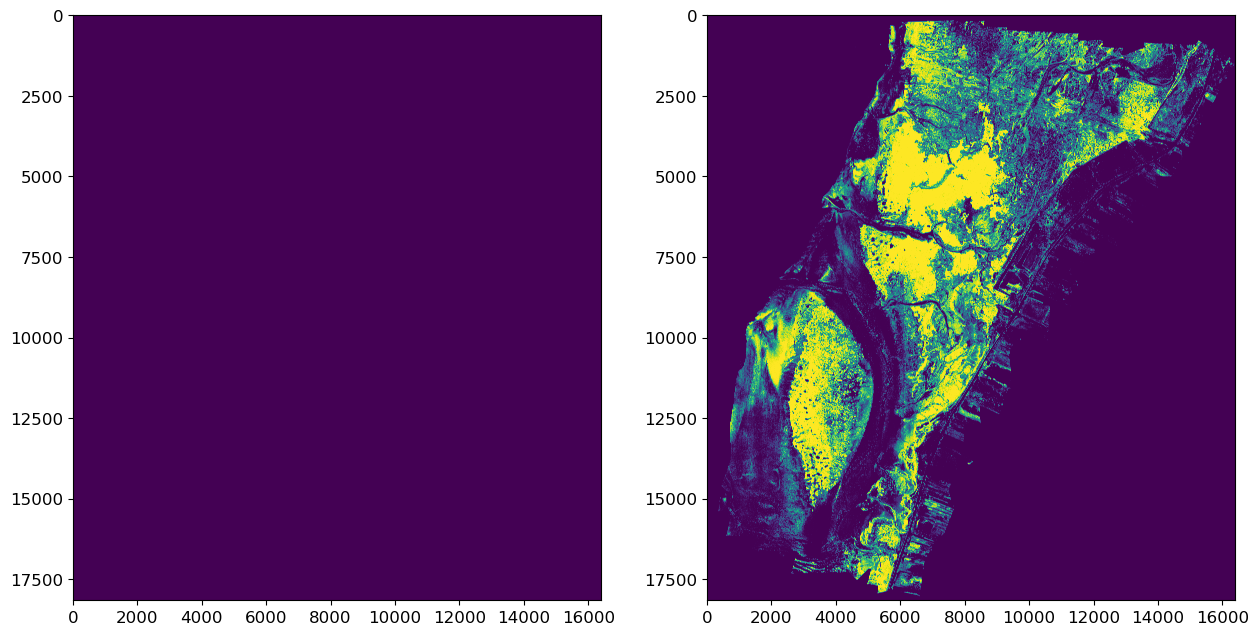

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,15))
# find minimum of minima & maximum of maxima
minmin = np.min([np.min(Chloro_ras), np.min(Zost_ras)])
maxmax = np.max([np.max(Chloro_ras), np.max(Zost_ras)])

im1 = axes[0].imshow(Chloro_ras, vmin=minmin, vmax=maxmax)
im2 = axes[1].imshow(Zost_ras, vmin=minmin, vmax=maxmax)
plt.show()

In [24]:
categories

['Bare_Sediment', 'Clorophyta', 'Deep_Sediment', 'Low_SPC', 'MPB', 'Magnoliosida', 'Phaeophyta', 'Rhodphyta', 'SunGlint', 'Water']

In [25]:
cmap = colors.ListedColormap(["#FFFFFF","#70543e","#b3ff1a","#389317","#000000","#DAA520","#389318","#873e23","#b3002d","#42c9bc"])
bounds=[0,1,2,3,4,5,6,7,8,9,10]
norm = colors.BoundaryNorm(bounds, cmap.N)

NameError: name 'rgb' is not defined

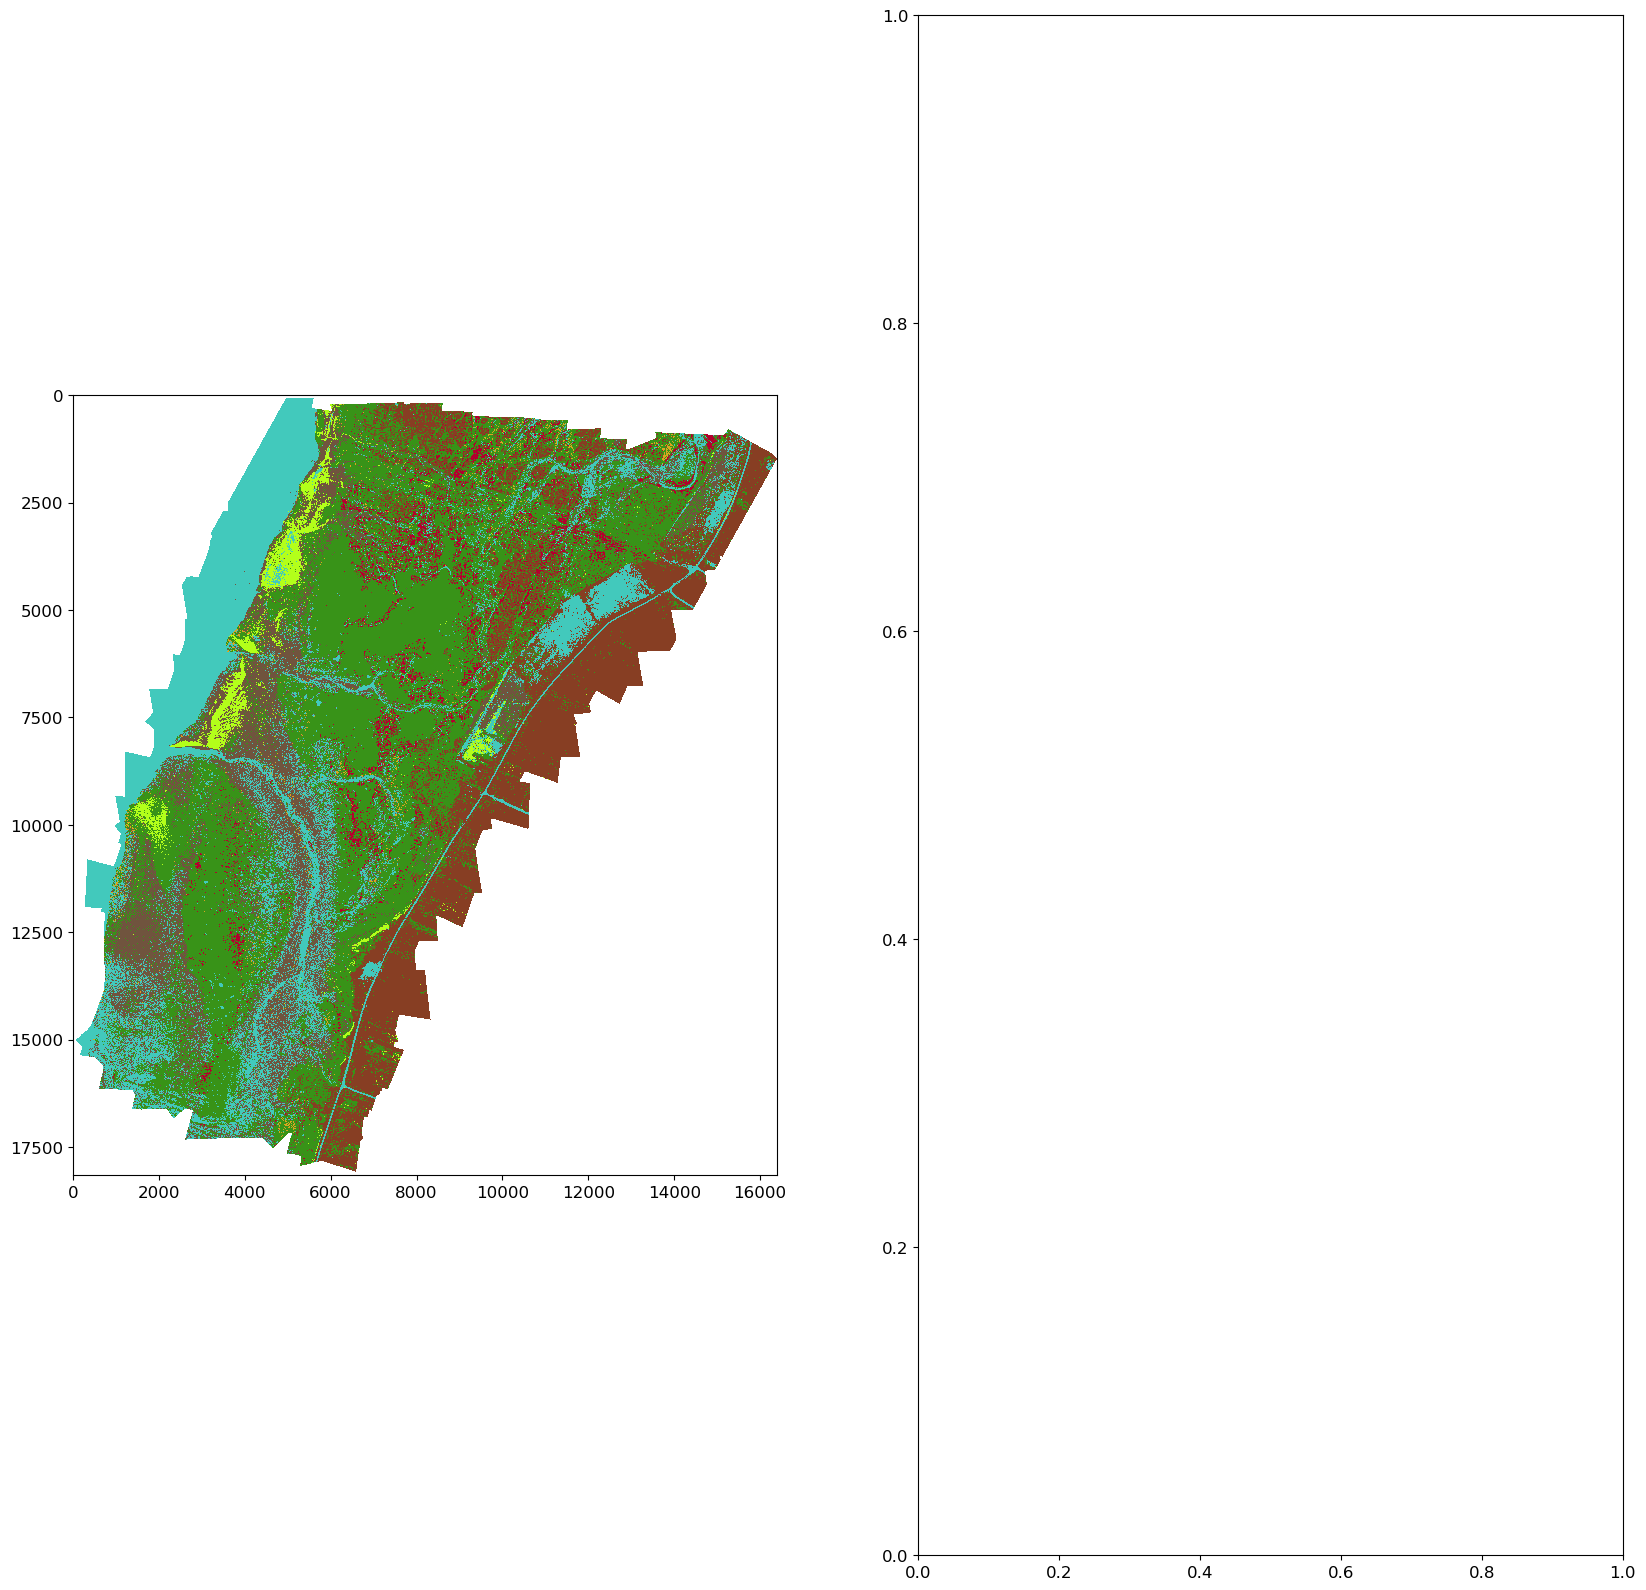

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,20))
ax1.imshow(Pred_ras, interpolation='none',
                    cmap=cmap, norm=norm)
ax2.imshow(rgb)
plt.show()

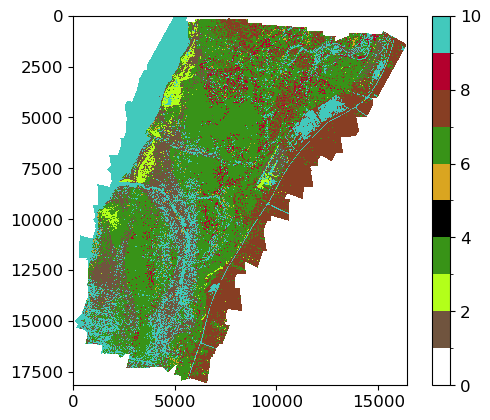

In [27]:
plt.figure()
plt.imshow(Pred_ras, interpolation='none',
                    cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

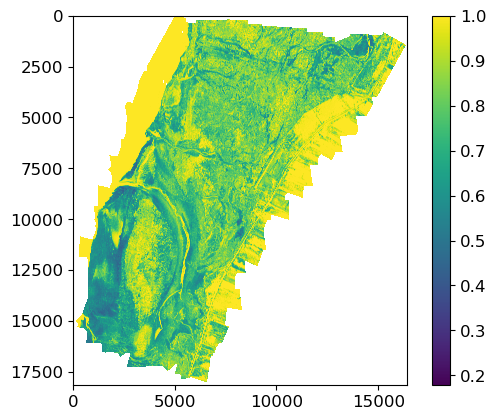

In [28]:
plt.figure()
plt.imshow(Prob_ras)
plt.colorbar()
plt.show()

In [29]:
AveiroLowPrediction_nnDefault =np.dstack((Pred_ras,Prob_ras))

# Prediction Save

In [30]:
# export
driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Predictions/AveiroHighPrediction_nnNewStanRawMetrics_Probs_NoXantho.tif", xsize = Prob_ras.shape[1],
                      ysize = Prob_ras.shape[0], bands = 1, 
                      eType = gdal.GDT_Float32)
outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)
outband.WriteArray(Prob_ras)
outband.SetNoDataValue(65535)
outband.FlushCache()

# close your datasets and bands!!!
outband = None
outds = None

driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("/Users/bfrd/Research/BigData/Nantes/Drone_Classification/Predictions/AveiroHighPrediction_nnNewStanRawMetrics_Pred_NoXantho.tif", xsize = Pred_ras.shape[1],
                      ysize = Pred_ras.shape[0], bands = 1, 
                      eType = gdal.GDT_Int16)
outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)
outband.WriteArray(Pred_ras)
outband.SetNoDataValue(65535)
outband.FlushCache()
# close your datasets and bands!!!
outband = None
outds = None